　ModelingToolkitやTuringなどのJuliaの道具がマーケティング的な発想と分析にどのように活用できるのかを試し、多くの人に利用してもらうことでユーザーの幅を広げることを目的としている。パッケージの詳細についてはそれぞれのマニュアルを参照されたい。ModelingToolkitは「微分方程式を記号的に扱う」パッケージで、TuringはMCMCという乱数発生アルゴリズムを利用し「パラメータを推定するパッケージ」という程度の理解でよい。

私の興味は産業の隆盛（ブーム）と衰退のメカニズムであり、ここでは具体例として「パチンコ」を取り上げる。1993年以降のパチンコユーザー調査を利用する。データは日本生産性本部の「レジャー白書」を参照している。

In [1]:
using CSV,StatsPlots,DataFrames

In [5]:
cd("C:\\Users\\kimse\\OneDrive\\Jupyter_notebook\\パチンコの微分方程式モデリング")

In [11]:
df = CSV.read("pdata.csv", DataFrame)

Row,Year,P_USER,V_PEOPLE
,Int64,Int64,Int64
1,1994,29300,125265
2,1995,29000,125570
3,1996,27600,125859
4,1997,23100,126157
5,1998,19800,126472
6,1999,18600,126667
7,2000,20200,126926
8,2001,19300,126926
9,2002,21700,127316


1994年のプレイヤー人口2930万から持続的に減少し2016年以降は1000万以下が常態となっている。プレイヤーの減少はどこまで続くのだろうか？

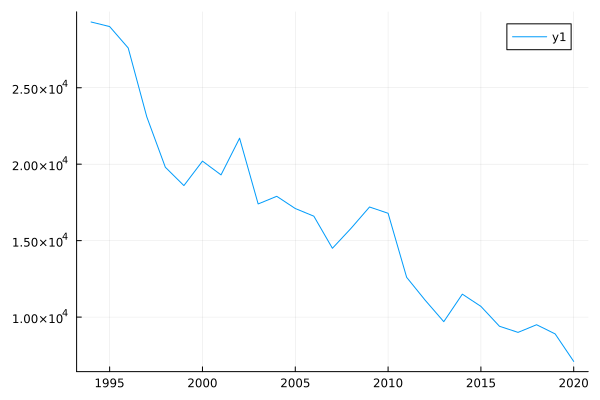

In [18]:
@df df plot(:Year,:P_USER)

### 数学は詳しくないので間違いが含まれていると思う。寛大な心でご指摘願いたい。

In [ ]:
using Catalyst,DifferentialEquations,StatsPlots
using ModelingToolkit

人類はパチンコプレイヤーとパチンコをやらない人（「ノンプレイヤー」）に二分される。ここでいう「パチンコプレイヤー」は年間で1回以上ホールで遊戯を行った人と定義される。プレイヤーのほとんどは20代のはじめに（多くは先輩や上司に連れられて）エントリーし、結婚や引っ越し、転職、金融状況、病気、価値観の変化などで遊戯を中断したり再開したりをする。何がプレイを再開させているのかはよくわかっていない。好きなコンテンツやキャラクターがそうさせる場合もあるし、近くにホールがあるとか、人間関係の変化かもしれない。しかしいずれにしてもそのような理由はプレイヤー・ノンプレイヤー全体に対して一定の確率で発生すると思われる。

プレイヤーはある一定の確率でノンプレイヤーになるし、ノンプレイヤーも一定の確率でプレイヤーになる。この関係を微分方程式に簡単に変換できるツールが　Catalyst.jl　である。はっきり言ってここでは紹介のために使ってみただけだ。

In [ ]:
rn = @reaction_network begin
    e, N --> P
    r, P --> N
end

ConvertでODESystemに変換できる。ここで微分方程式のデザインが確認できる

In [ ]:
convert(ODESystem, rn)

パラメータはの略語をこのように整理している
### Parameters
 - e =>パチンコ遊戯へのエントリーの係数、
 - r =>パチンコ遊戯を中断(retire）係数
 - b =>人口変動。死亡や誕生（birth）による人口全体の変動係数
 
### Variables
 - N => パチンコノンユーザー
 - P => パチンコユーザー
 - V => 人口全体（N＋P）

パチンコユーザー<=>ノンユーザーモデルの状態変数とパラメーターを設定する。teventはパラメータや状態に大きな変化を与えるイベント（カタストロフィーイベント）を記述するためだ。

In [ ]:
@variables t P(t) V(t) N(t)
@parameters  r e b tevent
D = Differential(t)

微分方程式のモデルを書く。人口の変動分dV(t)は死亡／誕生による差分なので、いずれもノンユーザーとしてモデルに組み込む。

In [ ]:
eqs = [ D(P) ~ e * ( V - P )  - r * P
        D(N) ~ r * P  - e *( V - P) + D(V)
        D(V) ~ b
        ]

In [ ]:
u0 = [P => 3.0 ,N => 9.0, V => 12.0]
ps = [b => -0.02, e => 0.03, r => 0.1]
tspan=(0,30.0)
@named sys = ODESystem(eqs, t)
sys = structural_simplify(sys)

prob = ODEProblem(sys, u0, tspan, ps)
sol = solve(prob)
plot(sol,idxs=[P])

In [ ]:
u0 = [P => 3.0 ,N => 9.0, V => 12.0]
ps = [b => -0.02, e => 0.03, r => 0.1]
tspan=(0,30.0)

#discrete_events  = [ (t > 10.0 ) =>  [ e ~ 0, r ~ 0] , (t > 16.0 ) =>  [ e ~ 0.03, r ~ 0.06] ]
event_10 = (t == 10 ) => [ P ~ P * 0.9 ] 
event_16 = (t == 16 ) => [ P ~ P * 0.9 ] 
@named sys_cata = ODESystem(eqs, t, [P,N,V], [b,e,r] ; discrete_events = [event_10, event_16])
sys_cata = structural_simplify(sys_cata) ;

In [ ]:
prob_cata = ODEProblem(sys_cata, u0, tspan, ps)
sol2 = solve(prob_cata ;tstops = [10.0, 16.0])
plot(sol2,idxs=[P])
plot!(sol,idxs=[P])

In [ ]:
using DataFrames, CSV

In [ ]:
dx = CSV.read(joinpath("..","Pachinko","p-datasets2.csv"),DataFrame)
for (i,e) in enumerate(names(dx))
    print("$i : $e ,")
end
eq = zeros(31) ; eq[23:end] .= 1.0
dx.eq = eq ;
#dx.パチンコ参加人口 = dx.パチンコ参加人口 .* 10 ;

In [ ]:
Pu = dx.パチンコ参加人口[6:end]
Vu = dx.総人口[6:end]
year = dx.年[6:end]
plot(year,[Pu,Vu])

In [ ]:
function serial(t; data=data)
    #@assert t < length(data) - 1
    if t < 1
        ff = data[1]
        nn = (data[2] - data[1]) * t
    else
        f = floor(t)
        n = t - f
        ff = data[ f+1 |> Int]
        ffn = f+2 > length(data) ? data[end] : data[(f+2) |> Int]
        if n != 0
            nn =  (ffn - ff ) * n 
        else
            nn = 0
        end
    end

    return ff+nn
end

In [ ]:
pu_func(t) = serial(t ; data=Pu)
vu_func(t) = serial(t ; data=Vu)

In [ ]:
xs = 0:0.1:length(Pu)-1
plot(xs,[pu_func(x) for x =xs],xticks=year)
plot!(0:length(Pu)-1,Pu)
vline!([2,16])

year

In [ ]:
using Zygote

In [ ]:
dvu(τ) = begin
    rs = gradient(x->vu_func(x), τ)[1]
    if rs == nothing 
        (dvu(τ + 0.1) + dvu( τ - 0.1))/2
    else
        rs
    end
end

In [ ]:
dvu(16) 

In [ ]:
d_vu =[dvu(t) for t in xs] ;

In [ ]:
plot(xs, d_vu)


In [ ]:
@variables t P(t) V(t) N(t)
@parameters  r e b 
D = Differential(t)

In [ ]:
@register_symbolic pu_func(t)
@register_symbolic vu_func(t)
@register_symbolic dvu(t)

## このモデルが正しい

In [ ]:
eqs = [ D(P) ~ e * ( V - P )  - r * P
        D(N) ~ r * P  - e *( V - P) + D(V)
        D(V) ~ b
        ]

In [ ]:
u0 = [P => 7.0 ,N => 10.0, V => 10.0]
ps = [b => -0.02, e => 0.25, r=> 0.2]
tspan=(0,30.0)
@named sys = ODESystem(eqs, t)
sys = structural_simplify(sys)

In [ ]:
prob_vs = ODEProblem(sys, u0, tspan, ps)
sol = solve(prob_vs)
plot(sol)

In [ ]:
eqs_v = [  D(P) ~ e * ( V - P )  - r * P
           D(N) ~ r * P  - e *( V - P) + D(V)
           D(V) ~ dvu(t)
        ]

In [ ]:
@named sysv = ODESystem(eqs_v, t)
sysv = structural_simplify(sysv)

In [ ]:
u0 = [P => Pu[1] ,N => Vu[1] - Pu[1] , V => Vu[1]]
ps = [e => 0.03, r=> 0.4]
tspan=(0,length(year)-1)
probv = ODEProblem(sysv, u0, tspan, ps)
solv = solve(probv)
plot(solv, idxs=[P])

In [ ]:
rprob=remake(probv ; u0 = [P => Pu[3] ,N => Vu[3] - Pu[3] , V => Vu[3]], p=[e=> 0.05, r=>0.4]) 
rsolv=solve(rprob, saveat=collect(0:25))
plot!(rsolv, idxs=[P])

In [ ]:
rsolv.u[2][1]

In [ ]:
using Turing, Distributions

In [ ]:
@model function findprm(prob, Px, Vx, ts) # findprm(Pu, Vu, probv)
    n = length(Px)
    entry  ~ truncated(TDist(3), 1e-3, 1 - 1e-3)
    retire ~ truncated(TDist(3), 1e-3, 1 - 1e-3 )
    s ~ InverseGamma(2,3)
    
    prob = remake(prob ; 
            u0= [ P => Px[1], N => Vx[1] - Px[1], V => Vx[1] ],
            p = [ e => entry, r => retire],
            tspan = ts
    )
    solv = solve(prob, saveat=collect(ts[1]:ts[end]) )
    
    for i = 1:n
        Px[i] ~ Normal(solv.u[i][1], s) 
    end
    return (; Ps = [])
end
    

In [ ]:
ts =  (0.0, 25.0 )
model = findprm(probv, Pu, Vu, ts)
chain = sample(model, NUTS(.64), 2000)

In [ ]:
rs = get(chain, [:entry, :retire])
ts_0 = (; e = rs[:entry]  |> mean　, r = rs[:retire] |> mean)

In [ ]:
rsol =solve( remake( probv, p = [e => ts_0.e, r => ts_0.r]) , saveat=collect(ts[1]:ts[end]))
plot(rsol, idxs=[P])
scatter!(0:ts[2], Pu)

In [ ]:
u0 = [P => Pu[1] ,N => Vu[1] - Pu[1] , V => Vu[1]]
ps = [e => ts_0.e, r => ts_0.r ]
tspan=(0,length(year)-1)
event_10 = ( t == 3 ) => [ P ~ P * 0.95 ] 
event_16 = ( t == 17 ) => [ P ~ P * 0.95 ] 
@named sys_cata = ODESystem(eqs_v, t, [P,N,V], [e,r] ; discrete_events = [event_10, event_16])
sys_cata = structural_simplify(sys_cata) 
prob_cata = ODEProblem(sys_cata, u0, tspan, ps)
sol = solve(prob_cata, saveat=collect(ts[1]:ts[end]), tstops = [3, 17.0])
plot(sol, idxs=[P] )
scatter!(0:ts[2], Pu)

In [ ]:
@model function findprmevent(prob, Px, Vx, ts ) # findprm(Pu, Vu, probv)
    n = length(Px)
    entry  ~ truncated(TDist(3), 1e-4, 1 - 1e-4)
    retire ~ truncated(TDist(3), 1e-4, 1 - 1e-4 )
    s ~ InverseGamma(2,3)
    
    prob = remake( prob ; 
            u0= [ P => Px[1], N => Vx[1] - Px[1], V => Vx[1] ],
            p = [ e => entry, r => retire],
            tspan = ts
    )
    solv = solve(prob ; saveat=collect(ts[1]:ts[end]) , tstops = [3.0, 17.0] )
    # t が繰り返される
    countlist=collect(1:26) |> t-> [e > 3 ? e + 3 : e for e in t] |> t->[e > 17 ? e + 3 : e for e in t]
    countlist[4] -= 1
    countlist[17] -= 1
    
    for (i,e) in enumerate(countlist)
        Px[i] ~ Normal(solv.u[e][1], s) 
    end
    return (; Ps = [])
end
    

    

In [ ]:
ts =  (0.0, 25.0 )
model = findprmevent(prob_cata, Pu, Vu, ts)
chain = sample(model, NUTS(.64), 2000)

In [ ]:
rs = get(chain, [:entry, :retire])
ec = rs[:entry]  |> mean
rc = rs[:retire] |> mean
ts_2 = (; e = ec, r = rc)

In [ ]:
rsol =solve( remake( prob_cata, p = [e => ts_2.e, r => ts_2.r]) ; tstops = [3, 17.0] )
plot(rsol, idxs=[P])
scatter!(0:ts[2], Pu)

In [ ]:
u0 = [P => Pu[1] ,N => Vu[1] - Pu[1] , V => Vu[1]]
ps = [e => ts_2.e, r => ts_2.r , b => -0.02]
tspan=(0, 100)
event_10 = (t == 3 ) => [ P ~ P * 0.9 ] 
event_16 = (t == 17 ) => [ P ~ P * 0.9 ]

@named sys_cata = ODESystem(eqs, t, [P,N,V], [e,r,b] ; discrete_events = [event_10, event_16])
sys_cata = structural_simplify(sys_cata) 
prob_cata = ODEProblem(sys_cata, u0, tspan, ps)
sol = solve(prob_cata, tstops = [3, 17.0])
plot(sol, idxs=[P] )
scatter!(0:ts[2], Pu)

In [ ]:
sol

In [ ]:
plot(Vu)

In [ ]:
plot(0:25,Pu,legend=false)
plot!(0:2, Pu[1:3],fill=(:orange, 0))
plot!(2:16,Pu[3:17],fill=(:green, 0))
plot!(16:25, Pu[17:26],fill=(:skyblue, 0))
vline!([2,16])

In [ ]:
model = findprm(probv,Pu[1:3], Vu[1:3], (0,2) )
chain = sample(model, NUTS(), 2000)

In [ ]:
rs = get(chain, [:entry, :retire])
ec = rs[:entry] |> mean
rc = rs[:retire] |> mean
ts_1 = (; e=ec, r=rc)

In [ ]:
plot(0:25,Pu,legend=false)
plot!(0:2, Pu[1:3],fill=(:white, 0))
plot!(2:16,Pu[3:17],fill=(:green, 0))
plot!(16:25, Pu[17:26],fill=(:white, 0))
vline!([2,16])

In [ ]:
ts = (2,16)
model = findprm(probv,Pu[3:17], Vu[3:17], ts)
chain = sample(model, NUTS(), 2000)

In [ ]:
rs = get(chain, [:entry, :retire])
ec = rs[:entry] |> mean
rc = rs[:retire] |> mean
ts_2 = (; e=ec, r=rc)

In [ ]:
utest = [ P => Pu[3], V => Vu[3], N => Pu[3]+Vu[3] ]
ptest = [ e => ts_2.e, r => ts_2.r ]
ttest = (2,16)
tsolv = remake(probv, u0=utest, p=ptest, tspan=ttest ) |> solve
plot(2:16, Pu[3:17])
plot!(tsolv, idxs=[P])

In [ ]:
plot(0:25,Pu,legend=false)
plot!(0:2, Pu[1:3],fill=(:white, 0))
plot!(2:16,Pu[3:17],fill=(:white, 0))
plot!(16:25, Pu[17:26],fill=(:skyblue, 0))
vline!([2,16])

In [ ]:
model = findprm(probv,Pu[17:26], Vu[17:26], (16,25) )
chain = sample(model, NUTS(), 2000)

In [ ]:
rs = get(chain, [:entry, :retire])
ec = rs[:entry] |> mean
rc = rs[:retire] |> mean
ts_3 = (; e=ec, r=rc)

In [ ]:
utest = [ P => Pu[17], V => Vu[17], N => Pu[17]+Vu[17] ]
ptest = [ e => ts_3.e, r => ts_3.r ]
ttest = (16,25)
tsolv = remake(probv, u0=utest, p=ptest, tspan=ttest) |> solve
plot(16:25, Pu[17:26])
plot!(tsolv, idxs=[P])

In [ ]:
u0 = [P => Pu[1] , N => Vu[1] - Pu[1] , V => Vu[1]]
ps = [e => ts_1.e, r => ts_1.r ]
tspan=(0,25)

inverse_func  = [ (t >  2.0 ) =>  [ e ~ ts_2.e, r ~ ts_2.r] ,
                  (t > 16.0 ) =>  [ e ~ ts_3.e, r ~ ts_3.r] ]

@named syv = ODESystem(eqs_v, t ;  discrete_events = inverse_func )
syv = structural_simplify(syv)

In [ ]:
prob_cr = ODEProblem(syv, u0, tspan, ps)
solcr = solve(prob_cr);
plot(solcr, idxs=[P])
plot!(0:tspan[2],Pu,label="Observed")
vline!([2,16], 
label="1996 & 2011")

In [ ]:
noize = [0.05*P, 0.05*V, 0.05*N]

In [ ]:
#@named de = SDESystem(eqs_v, noize, t, [P,N, V], [e,r]; tspan=tspan)
@named de = SDESystem(sysv, noize)

In [ ]:
u0 = [P => Pu[1] ,N => Vu[1] - Pu[1] , V => Vu[1]]
ps = [e => ts_1.e, r => ts_1.r ]
tspan=(0,length(year)-1)

In [ ]:
probe = SDEProblem(de, u0, tspan, ps)

In [ ]:
sole = solve(probe);
plot(sole,idxs=[P])
plot!(0:tspan[2],Pu)

In [ ]:
eqs_v

In [ ]:
catastrophe = [ [t ~  3.0]  =>  [ P ~ 0.8 * P ] 
                [t ~ 16.0]  =>  [ P ~ 0.9 * P ] ]

@named sys_cata = ODESystem(eqs_v, t ;  
       # discrete_events = catastrophe, 
        continuous_events = catastrophe )
sys_cata = structural_simplify(sys_cata)

In [ ]:
u0 = [P => Pu[1] ,N => Vu[1] - Pu[1] , V => Vu[1]]
ps = [e => 0.03, r => 0.04 ]
tspan=(0,length(year)-1)
prob_cata = ODEProblem(sys_cata, u0, tspan, ps)

In [ ]:
solc = solve(prob_cata);
plot(solc,idxs=[P])
plot!(0:tspan[2],Pu)
plot!(solv, idxs=[P])

In [ ]:
model = findprm(prob_cata, Pu, Vu, (0,25) )
c_cata = sample(model, NUTS(), 2000)

In [ ]:
rs = get(c_chain, [:entry, :retire])
ec = rs[:entry] |> mean
rc = rs[:retire] |> mean
ts_ct = (; e=ec, r=rc)

In [ ]:
utest = [ P => Pu[1], V => Vu[1], N => Pu[1]+Vu[1] ]
ptest = [ e => ts_ct.e, r => ts_ct.r ]
ttest = (0,25)
tsolv = remake(prob_ct, u0=utest, p=ptest, tspan=ttest) |> solve
plot(0:25, Pu)
plot!(tsolv, idxs=[P])

In [ ]:
ts_3

カタストロフィーに対して行動の変化が持続的である前提となっている。
もしかするとカタストロフィーイベントによってボリュームが一度に離脱したかもしれない